# Visualizing Fleet Distances


I was having discussion with friend about how one could visualize the geographical coverage of a service fleet for a known set of customers.  For example, if set A is a set of students and B is a set of tutors, we are interested in being able to plot areas which are lacking a good student to tutor ratio, given expected reasonable threshold of distance for the student to travel to get to the tutor.

In [4]:
import pandas as pd
from numpy.random import rand
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import  cm

%matplotlib inline

### Make a sample set of customers and providers

Lets make some fake data sets. For simplicity, I'm just going to work with cartesian coordinates, but if you had real data it would be easy to transition this into latitude longitude.

In [5]:
def create_data(n, xrange, yrange):
    """ A function to create a dummy data set for plotting """
    return pd.DataFrame({"x":rand(n)*yrange, "y":rand(n)*xrange,'name':range(n)})

In [36]:
xrange=10
yrange=10
C = create_data(10,xrange,yrange)
P = create_data(20,xrange,yrange)

In [37]:
C.head()

,name,x,y
0,0,3.163295,3.537100
1,1,3.533921,1.471155
2,2,3.756294,2.340282
3,3,6.698368,4.051499
4,4,0.864397,1.279402


### Create gridded summary of density
We can summarize the density of the customers or providers in each area by generating a grid for the area of interest at a resolution of our choice, and then counting the providers or customers within a threshold of those points. Note that the choice of the number of gridpoints should probably result in a resolution of at most half of the desired distance threshold to have a meaningful plot.

In [38]:
gridpoints = 50

# The x and y coodinates of the grid
X,Y = np.meshgrid(np.linspace(0,xrange,gridpoints),np.linspace(0,yrange,gridpoints))

# The arrays which will hold the values for the proximate elements at that grid point.
# For Customers
N_C = np.zeros((gridpoints,gridpoints))
# and for Providers
N_P = np.zeros((gridpoints,gridpoints))

# A matrix to store the ratio of providers per customer within the threshold distance of this gridpoint
P_per_C = np.zeros((gridpoints,gridpoints))

Specify the theshold distance that a provider must be within, to be considered within range of a customer.

In [133]:
threshold = 2

if (xrange/gridpoints) > (threshold/2) or (yrange/gridpoints) > (threshold/2):
    print("Warning, grid resolution is too low {},{} vs threshold {}".format(xrange/gridpoints,yrange/gridpoints, threshold) )


Define some functions for calculating distance.  This uses euclidian distance, though the arguement could be made for manhattan distance.

In [134]:
def griddistance(row,x,y):
    """ Calculate cartesian distance for a row with attributes, x and y """
    return np.sqrt((row.x-x)**2+(row.y-y)**2)

def units_in_threshold(x, y ,A ,threshold):
    """ For a pandas series, A, calculate the distance of all points from
        given x,y coordinates, and return the number of values within a distance threshold"""
    distance = A.apply(griddistance,args=(x,y),raw=True,axis=1)   
    return (distance[distance<threshold].count() or 0)

For each point in the grid, record the number of customers or providers within the threshold distance.  Also calculate the ratio of provider to customer where applicable.  I know there is a way to do this that is vectorized and more beautiful, but for clarity  I'm putting up with using loops.

In [135]:
for i in range(gridpoints):
    for j in range(gridpoints):
        C_density = units_in_threshold(X[i, j], Y[i, j], C, threshold)
        P_density = units_in_threshold(X[i, j], Y[i, j], P, threshold)

        N_C[i,j]=C_density
        N_P[i,j]=P_density
        if C_density>0:
            P_per_C[i,j] = P_density/C_density
        else:
            P_per_C[i,j] = np.nan

Make some contour plots

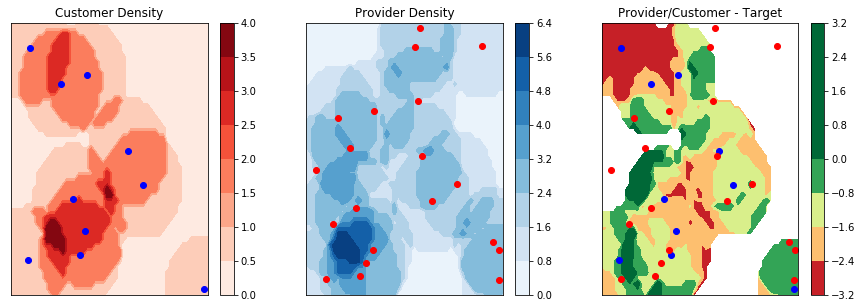

In [122]:

f, axes = plt.subplots(1,3, sharex=True, sharey=True,  figsize=(15, 5)  )
# First plot the Customer Density
c1=axes[0].contourf(X, Y, N_C, 
                    cmap=cm.Reds, 
                   # norm=cm.colors.Normalize(vmax=N_C.max(), vmin=0)
                   )
axes[0].scatter(C.x,C.y, color='b')
axes[0].set_title('Customer Density')
plt.colorbar(c1,ax=axes[0])
axes[0].tick_params(axis='both', left='off', top='off', right='off', bottom='off', labelleft='off', labeltop='off', labelright='off', labelbottom='off')

# THen the Provider Density
c2=axes[1].contourf(X, Y, N_P, 
                    cmap=cm.Blues, 
                   )
axes[1].scatter(P.x,P.y, color='r' )
axes[1].set_title('Provider Density')
plt.colorbar(c2,ax=axes[1])
axes[1].tick_params(axis='both', left='off', top='off', right='off', bottom='off', labelleft='off', labeltop='off', labelright='off', labelbottom='off')

# Finally plot the shortfall of coverage at each location, based on the provider density
target_P_per_C = 3
c3=axes[2].contourf(X, Y, P_per_C-target_P_per_C, 
                    cmap=cm.RdYlGn, 
                    norm=cm.colors.Normalize(vmax=0, vmin=-target_P_per_C))
axes[2].scatter(C.x,C.y, color='b',label='Customers')
axes[2].scatter(P.x,P.y, color='r',label='Providers')
axes[2].set_title('Provider/Customer - Target')
plt.colorbar(c3,ax=axes[2])
axes[2].tick_params(axis='both', left='off', top='off', right='off', bottom='off', labelleft='off', labeltop='off', labelright='off', labelbottom='off')


The third chart shows one way of evaluating the coverage.  Areas which would not impact customers are null, and show as white.  Within those areas which impact customers, the density of coverage is shown, offset by the target number of providers.  You can interpret this by saying that any areas which are dark green would result in users with sufficient coverage.

One thing I don't love about this approach is that it only calculates the distance from the grid point to the provider, so you could have a situation where the distance from customer to provider is up to twice that of the threshold.  Also, if you have a customer who has sufficient providers to the north of them, it can indicate that providers are desirable to the south of them, even when this is not necessary.

## Visualizing customer coverage
As an alternative, instead of simply combining the density of the providers and customers, we could create a score which tabulates the customer which dont have sufficient providers within their theshold for the customers within the threshold of the gridpoint.  This will give you the value of adding a provider at  given grid point, and can increase that value if it can benefit multiple customers.

To do this, first, calculate the distance for every customer to every provider.  If you are working with a big data set, this should probably be precalculated, could potentially benefit from optimization.  For the purpose of demonstration I am simply cross joining the two sets, and applying the distance calculation to all combinations.

In [123]:
# in order to get a cross join from our merge, we have to make a dummy key
C.loc[:,'key']=0
P.loc[:,'key']=0

PC = C.merge(P, how='outer',on='key', suffixes=('C','P'))

# Calculate the distance for each combination of customer and provider
def rowdist(row):
    return  np.sqrt((row.xC-row.xP)**2+(row.yC-row.yP)**2)
PC.loc[:,'distance'] = PC.apply(rowdist, axis=1)

# Calculate if the provider is within the threshold distance
PC.loc[:,'provider_count'] = (PC.distance<threshold).astype(int)

PC.head()

,nameC,xC,yC,key,nameP,xP,yP,distance,provider_count
0,0,3.163295,3.5371,0,0,5.772868,9.809474,6.793566,0
1,0,3.163295,3.5371,0,1,6.368603,3.446142,3.206598,0
2,0,3.163295,3.5371,0,2,3.038311,1.164073,2.376316,0
3,0,3.163295,3.5371,0,3,1.636851,6.504074,3.336610,0
4,0,3.163295,3.5371,0,4,2.226109,5.411211,2.095379,0


Once you have calculated the distance between each customer and provider, summarize the number of providers available to that customer.

In [124]:
newC = C.copy().set_index('name')
newC = C.join(PC.groupby('nameC').provider_count.sum().to_frame())
newC

,name,x,y,key,provider_count
0,0,3.163295,3.537100,0,2
1,1,3.533921,1.471155,0,4
2,2,3.756294,2.340282,0,4
3,3,6.698368,4.051499,0,3
4,4,0.864397,1.279402,0,3
5,5,9.790715,0.200366,0,3
6,6,0.968253,9.067043,0,0
7,7,3.870891,8.088960,0,2
8,8,2.533923,7.765609,0,2
9,9,5.946741,5.293583,0,3


Now for each gridpoint, calculate the number of customers which could use a provider in this location.  You can also calculate the number of customers impacted at each gridpoint, to understand the value of different locations.

In [128]:
def customers_in_threshold(x, y ,A ,threshold):
    """ For a pandas series, A, calculate the distance of all points from
        given x,y coordinates, and return the customers withnin that distance"""
    distance = A.apply(griddistance,args=(x,y),raw=True,axis=1)   
    return A[distance<threshold]

In [136]:
Customers_shortfall = np.zeros((gridpoints,gridpoints))

for i in range(gridpoints):
    for j in range(gridpoints):
        if N_C[i,j]>0:
            S = customers_in_threshold(X[i, j], Y[i, j],newC ,threshold)
            Customers_shortfall[i, j] = (S[S.provider_count<target_P_per_C].provider_count).count()
        else:
            Customers_shortfall[i, j] = np.nan

Make the plots

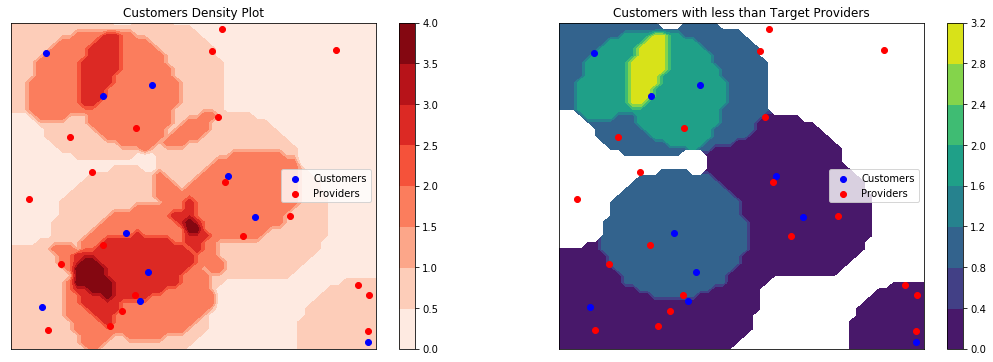

In [137]:
f, axes = plt.subplots(1,2, sharex=True, sharey=True,  figsize=(18, 6)  )
c1=axes[0].contourf(X, Y, N_C, 
                    cmap=cm.Reds)
axes[0].scatter(C.x,C.y, color='b',label='Customers')
axes[0].scatter(P.x,P.y, color='r',label='Providers')
axes[0].set_title('Customers Density Plot')
plt.colorbar(c1,ax=axes[0])
axes[0].legend()
axes[0].tick_params(axis='both', left='off', top='off', right='off', bottom='off', labelleft='off', labeltop='off', labelright='off', labelbottom='off')

c2=axes[1].contourf(X, Y, Customers_shortfall, 
                    cmap=cm.viridis,
                    norm=cm.colors.Normalize( vmin=0))
axes[1].scatter(C.x,C.y, color='b',label='Customers')
axes[1].scatter(P.x,P.y, color='r',label='Providers')
axes[1].set_title('Customers with less than Target Providers')
plt.colorbar(c2,ax=axes[1])
axes[1].legend()
axes[1].tick_params(axis='both', left='off', top='off', right='off', bottom='off', labelleft='off', labeltop='off', labelright='off', labelbottom='off')



In this case, the second plot shows what we are interested in.  The purple areas have sufficient coverage.  Providers in the blank areas are unnecessary.  The area which would be most beneficial to get a new provider in is in yellow.